In [1]:
import os
import rasterio
import numpy as np
import torch
from torch.utils.data import Dataset 
import cv2
import json
from skimage import feature
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern 
from functools import partial

# ---------- Helper functions ---------- #

def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([2, 3, 4, 5, 6, 7, 8, 10, 11])
    image = image / 10000.0
    return image

def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        return src.read(1)

def load_confidence(conf_path):
    with rasterio.open(conf_path) as src:
        return src.read(1)

def load_label_mapping(label_mapping_path):
    with open(label_mapping_path, 'r') as f:
        return json.load(f)

def compute_ndvi(b4, b8):
    return (b8 - b4) / (b8 + b4)
def compute_ndwi(b3, b8):
    return (b3 - b8) / (b3 + b8)
def compute_fdi(b6, b8, b10):
    r_acc = b6 + (b10 - b6) * ((833 - 740) / (1614 - 740))
    return b8 - r_acc
def standardize(image):
    mean = np.mean(image, axis=(1, 2), keepdims=True)
    std = np.std(image, axis=(1, 2), keepdims=True)
    return (image - mean) / std

def clip_values(image, min_value, max_value):
    return np.clip(image, min_value, max_value)

def histogram_equalization(image):
    return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])

def remove_clouds_and_water(image, mask, ndwi_image, conf_mask, threshold=-0.2):
   # Mask out clouds (from the confidence level) and water (from NDWI),
   # Removes areas from the image that correspond to clouds (based on confidence) or water (based on NDWI).

    cloud_mask = conf_mask != 1  # Low confidence (clouds)
    water_mask = ndwi_image < threshold  # Water (NDWI)
    
    # Set all pixels in cloud or water areas to zero
    image[:, cloud_mask | water_mask] = 0
    mask[cloud_mask | water_mask] = 255  # Set water/cloud pixels in the mask to 255
    
    return image, mask

def pad_image(image, target_size=(256, 256)):
    h, w = image.shape[1], image.shape[2]
    top = (target_size[0] - h) // 2
    bottom = target_size[0] - h - top
    left = (target_size[1] - w) // 2
    right = target_size[1] - w - left
    return np.pad(image, ((0, 0), (top, bottom), (left, right)), mode='constant', constant_values=0)

def glcm_feature(image):
    image = image.astype(np.uint8)
    glcm = graycomatrix(image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    asm = graycoprops(glcm, 'ASM')
    return contrast.item(), dissimilarity.item(), homogeneity.item(), energy.item(), correlation.item(), asm.item()

def texture(image):
    image_rgb = image.transpose(1, 2, 0)
    gray = rgb2gray(image_rgb)
    lbp = local_binary_pattern(gray, P=8, R=1.0, method="uniform")
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())
    return lbp.astype(np.float32)

# ---------- Main Dataset class ---------- #

class MaridaDataset(Dataset):
    def __init__(self, patch_dir, label_mapping_path=None, transform=None):
        self.patch_dir = patch_dir
        self.label_mapping = load_label_mapping(label_mapping_path) if label_mapping_path else None
        self.transform = transform
        self.sample_list = self._build_sample_list()

    def _build_sample_list(self):
        sample_list = []
        for folder in sorted(os.listdir(self.patch_dir)):
            folder_path = os.path.join(self.patch_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            for file in os.listdir(folder_path):
                if file.endswith(".tif") and "_cl" not in file and "_conf" not in file:
                    patch_num = file.replace(".tif", "")
                    sample_list.append((folder, patch_num))
        return sample_list

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        folder, patch_num = self.sample_list[idx]
        subfolder_path = os.path.join(self.patch_dir, folder)
        image_path = os.path.join(subfolder_path, f"{patch_num}.tif")
        mask_path = os.path.join(subfolder_path, f"{patch_num}_cl.tif")
        conf_path = os.path.join(subfolder_path, f"{patch_num}_conf.tif")

        label_list = self.label_mapping.get(f"{patch_num}.tif", [0]*15)
        # print(f"label list={label_list} count={len(label_list)} -- {label_list[0]}")
        image = load_image(image_path)
        mask = load_mask(mask_path)
        conf_mask = load_confidence(conf_path)

        LABEL_REMAP = {
            1: 0,   # Marine Debris -> 0 (target class)
            2: 1,   # Dense Sargassum -> 1
            3: 1,   # Sparse Sargassum -> 1
            4: 1,   # Natural Organic Material -> 1
            5: 255, # Ship -> Ignore
            6: 255, # Clouds -> Ignore
            7: 2,   # Marine Water -> 2
            8: 2,   # Sediment-Laden Water -> 2
            9: 255, # Foam -> Ignore
            10: 2,  # Turbid Water -> 2
            11: 2,  # Shallow Water -> 2
            12: 2,  # Waves -> 2
            13: 255,# Cloud Shadows -> Ignore
            14: 2,  # Wakes -> 2
            15: 2,  # Mixed Water -> 2
            255: 255 # Ignore
        }

        #Convert mask from 1-based to 0-based
        # mask = mask - 1
        mask[conf_mask != 3] = 255 
        mask[mask < 0] = 255  # if background or ignore regions are encoded as 0
        mask = np.nan_to_num(mask)
        #remapping
        mask_remapped = np.copy(mask)
        for original, new in LABEL_REMAP.items():
            mask_remapped[mask == original] = new

        mask = mask_remapped

        # if idx % 100 == 0:
        #     unique_vals, counts = np.unique(mask, return_counts=True)
        #     print(f"[{patch_num}] Class distribution:", dict(zip(unique_vals, counts)))
        #
        # unique_vals = np.unique(mask)
        # print(f"mask = {mask[0]}")
        unique_vals, counts = np.unique(mask, return_counts=True)
        # print(dict(zip(unique_vals, counts)))
        image = np.array([cv2.resize(band, (256, 256)) for band in image])
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        conf_mask = cv2.resize(conf_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        ndvi_image = compute_ndvi(image[2], image[6])
        ndwi_image = compute_ndwi(image[1], image[6])
        fdi_image = compute_fdi(image[4], image[6], image[7])
        ndvi_image = np.nan_to_num(ndvi_image)
        ndwi_image = np.nan_to_num(ndwi_image)
        fdi_image = np.nan_to_num(fdi_image)
        texture_features = texture(image[:3])
        texture_features_np = texture_features.astype(np.uint8)
        contrast, dissimilarity, homogeneity, energy, correlation, asm = glcm_feature(texture_features_np)
        glcm_features = np.array([contrast, dissimilarity, homogeneity, energy, correlation, asm])


        # image, mask = remove_clouds_and_water(image, mask, ndwi_image, conf_mask)

        ndvi_image = clip_values(ndvi_image, -1, 1)
        ndwi_image = clip_values(ndwi_image, -1, 1)
        fdi_image = clip_values(fdi_image, -1, 1)

        image = histogram_equalization(image)
        image = standardize(image)

        features = np.stack([
            image[0], image[1], image[2],
            ndvi_image, ndwi_image, fdi_image,
            texture_features,
        ], axis=0)

        glcm_features_reshaped = np.repeat(glcm_features, 256 * 256).reshape(6, 256, 256)
        features = np.concatenate([features, glcm_features_reshaped], axis=0)
        features = np.concatenate([features, conf_mask[np.newaxis, ...]], axis=0)

        if self.transform:
            features = self.transform(features)

        features = pad_image(features)

        features_tensor = torch.tensor(features, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)
        conf_mask_tensor = torch.tensor(conf_mask, dtype=torch.float32)

        return features_tensor, mask_tensor, conf_mask_tensor

In [2]:
patch_dir = "MARIDA/patches"
label_mapping_path = "MARIDA/labels_mapping.txt"

dataset = MaridaDataset(patch_dir=patch_dir, label_mapping_path=label_mapping_path)

image, mask ,conf = dataset[6]
# print(image)  # Should be (3, 256, 256)
print(mask)   # 

unique_vals, counts = np.unique(mask.numpy(), return_counts=True)
print("Mask label distribution:", dict(zip(unique_vals, counts)))

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])
Mask label distribution: {np.int64(255): np.int64(65536)}


/home/godwin/project/thiese project/thiese_env/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipykernel_2403269/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std


In [3]:
class_names = {
        0: 'Marine Debris',
        1: 'Organic',
        2: 'Water Surface',
        # 255: 'Ignore'
    }
def plot_class_distribution(dataset, num_samples=2000):
    from collections import Counter
    import matplotlib.pyplot as plt

    # Label dictionary (without background class 0)
 

    total_counts = Counter()
    for i in range(len(dataset)): 
    # for i in range(min(len(dataset), num_samples)):
        _, mask, _ = dataset[i]
        mask_np = mask.numpy().flatten()
        total_counts.update(mask_np)
    
    # Remove background class 0 from plotting
    # if 0 in total_counts:
    #     del total_counts[0]

    labels = [i for i in total_counts.keys() if int(i) != 255]
    #for selecting all labels including ignore(255)
    # labels = list(total_counts.keys())
    counts = [total_counts[k] for k in labels]
    label_names = [class_names.get(int(l), f"Class {l}") for l in labels]
    print(dict(zip(label_names,counts)))
    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(label_names, counts, color='teal')
    plt.xticks(rotation=45, ha='right')
    plt.title("Pixel Class Distribution (Excluding Background)")
    plt.xlabel("Class")
    plt.ylabel("Pixel Count")
    plt.tight_layout()
    plt.show()


In [4]:
plot_class_distribution(dataset)

/home/godwin/project/thiese project/thiese_env/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipykernel_2403269/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2403269/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2403269/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2403269/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


KeyboardInterrupt: 

Shows pixel disribution across classes,helps to understand the class imbalance.

In [ ]:
import numpy as np
from collections import Counter
LABELS = class_names

def print_class_distribution(mask_tensor):
    values, counts = np.unique(mask_tensor.numpy(), return_counts=True)
    distribution = dict(zip(values, counts))
    for k, v in distribution.items():
        print(f"Class {k}: {LABELS.get(k, 'Unknown')} -> {v} pixels")

import matplotlib.pyplot as plt
import numpy as np

def plot_pixel_distribution(mask_tensor, label_map):
    values, counts = np.unique(mask_tensor.numpy(), return_counts=True)
    labels = [label_map.get(int(v), str(v)) for v in values]

    plt.figure(figsize=(12, 4))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("Pixel Class Distribution")
    plt.ylabel("Pixel Count")
    plt.show()


In [ ]:
debris_patch_count = 0
for i in range(len(dataset)):
    _, mask, _ = dataset[i]
    if (mask == 0).sum() > 0:  # Class 0 is Marine Debris
        debris_patch_count += 1
print(f"{debris_patch_count} / {len(dataset)} patches contain Marine Debris")


/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


184 / 1381 patches contain Marine Debris


how fragmented or dense marine debris regions are.

/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


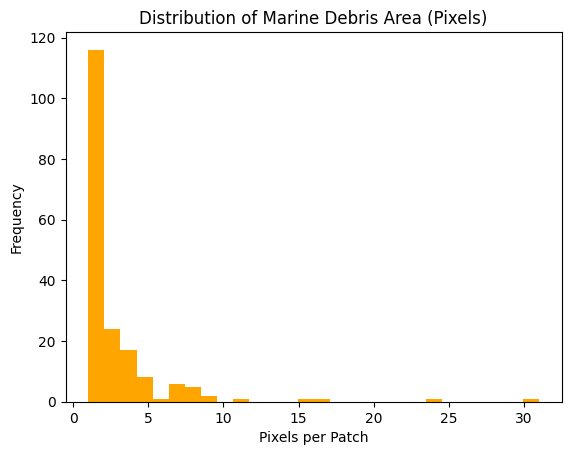

In [ ]:
debris_areas = []
for i in range(len(dataset)):
    _, mask, _ = dataset[i]
    count = (mask == 0).sum()
    if count > 0:
        debris_areas.append(count)

plt.hist(debris_areas, bins=28, color='orange')
plt.title("Distribution of Marine Debris Area (Pixels)")
plt.xlabel("Pixels per Patch")
plt.ylabel("Frequency")
plt.show()


the graph shows debris disribution accross patches if debris distibution across patches is less than 10 model might baised toward prediction "No debris" here debris distribution is more than 10%

 Co-occurrence of Classes 

Check which classes tend to appear with Marine Debris.

In [ ]:
from collections import defaultdict
co_occurrence = defaultdict(int)

for i in range(len(dataset)):
    _, mask, _ = dataset[i]
    classes = set(mask.numpy().flatten())
    if 0 in classes:  # debris present
        for cls in classes:
            if cls != 0 and cls != 255:
                co_occurrence[int(cls)] += 1

print("Classes that commonly co-occur with Marine Debris:")
for cls, count in co_occurrence.items():
    print(f"{class_names.get(cls, cls)}: {count}")


/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


Classes that commonly co-occur with Marine Debris:
Organic: 16


Designing smarter class groups (merging or separating similar-looking things)
Prioritizing classes to keep in your model

Overlay debris presence per pixel position across dataset to spot positional biases.

/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


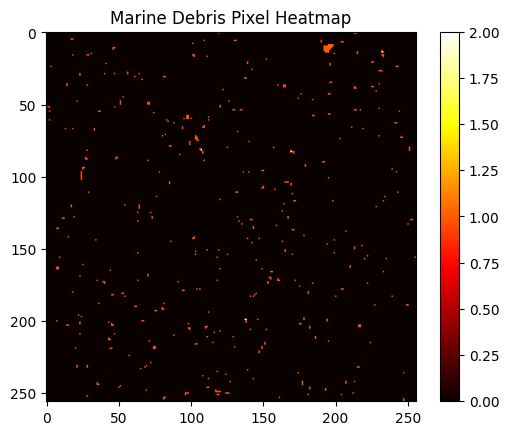

In [ ]:
heatmap = np.zeros((256, 256))
for i in range(len(dataset)):
    _, mask, _ = dataset[i]
    heatmap += (mask.numpy() == 0).astype(np.float32)

plt.imshow(heatmap, cmap='hot')
plt.title("Marine Debris Pixel Heatmap")
plt.colorbar()
plt.show()


/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


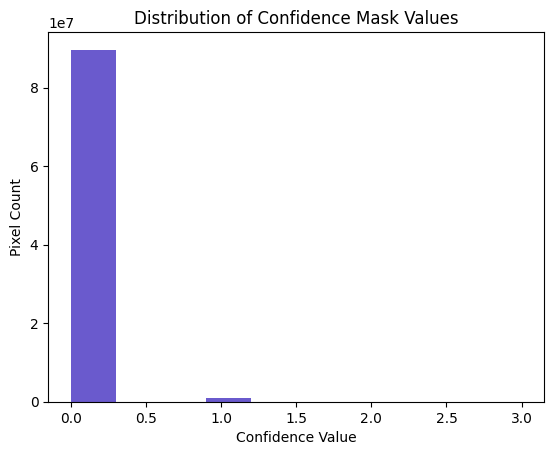

In [ ]:
conf_vals = []

for i in range(len(dataset)):
    _, _, conf = dataset[i]
    conf_vals.extend(conf.numpy().flatten())

plt.hist(conf_vals, bins=10, color='slateblue')
plt.title("Distribution of Confidence Mask Values")
plt.xlabel("Confidence Value")
plt.ylabel("Pixel Count")
plt.show()


/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


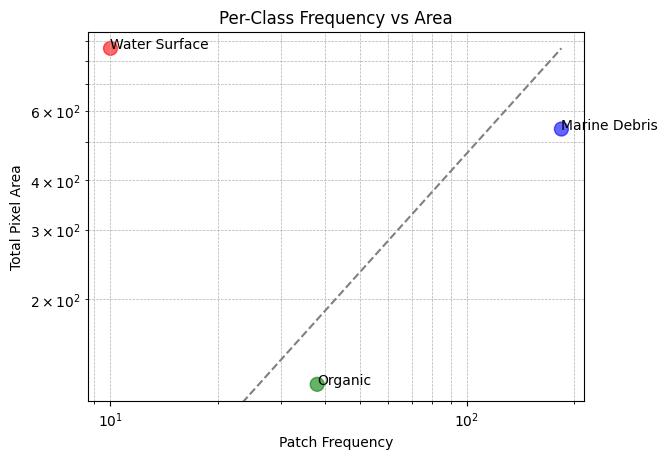

In [ ]:
area_per_class = {}
patch_freq = {}

for i in range(len(dataset)):
    _, mask, _ = dataset[i]
    unique, counts = np.unique(mask.numpy(), return_counts=True)
    for u, c in zip(unique, counts):
        if u == 255: continue
        area_per_class[u] = area_per_class.get(u, 0) + c
        patch_freq[u] = patch_freq.get(u, 0) + 1

classes = list(area_per_class.keys())
sizes = [area_per_class[c] for c in classes]
freqs = [patch_freq[c] for c in classes]
labels = [class_names.get(c, f'Class {c}') for c in classes]
colors = ['blue', 'green', 'red']  # Match order of your classes
plt.scatter(freqs, sizes, s=100, alpha=0.6, c=colors)
for i, label in enumerate(labels):
    plt.text(freqs[i], sizes[i], label)
plt.xlabel("Patch Frequency")
plt.ylabel("Total Pixel Area")
plt.title("Per-Class Frequency vs Area")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.plot([0, max(freqs)], [0, max(sizes)], linestyle='dashed', color='gray')
plt.show()


Highlights Class Imbalance
It shows how uneven your dataset is:

Marine Debris: High frequency but moderate area
Water Surface: Appears in fewer patches but takes up a lot of space
Organic Material: Rare and small


/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


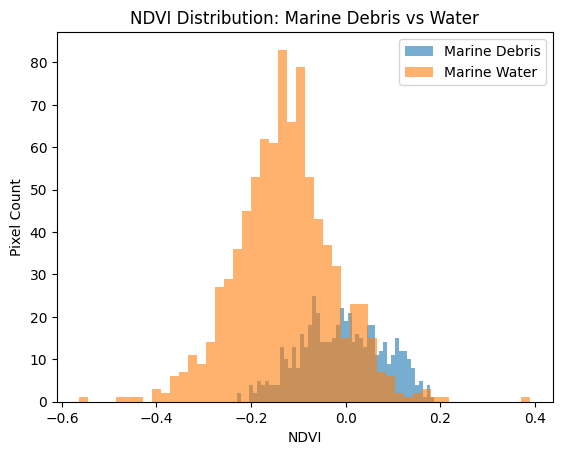

In [ ]:
debris_ndvi = []
water_ndvi = []

for i in range(len(dataset)):
    image, mask, _ = dataset[i]
    ndvi = image[3].numpy()  # assuming channel 3 is NDVI
    debris_ndvi.extend(ndvi[mask == 0])
    water_ndvi.extend(ndvi[mask == 2])

plt.hist(debris_ndvi, bins=50, alpha=0.6, label="Marine Debris")
plt.hist(water_ndvi, bins=50, alpha=0.6, label="Marine Water")
plt.title("NDVI Distribution: Marine Debris vs Water")
plt.xlabel("NDVI")
plt.ylabel("Pixel Count")
plt.legend()
plt.show()


there is an overlap in the class but debris pixels have a distinct feature beahviour.this helps to undertsnd distiguishen between marine debris disribution and marine water.

/tmp/ipykernel_2296888/1780179911.py:43: RuntimeWarning: invalid value encountered in divide
  return (image - mean) / std
/tmp/ipykernel_2296888/1780179911.py:34: RuntimeWarning: invalid value encountered in divide
  return (b8 - b4) / (b8 + b4)
/tmp/ipykernel_2296888/1780179911.py:36: RuntimeWarning: invalid value encountered in divide
  return (b3 - b8) / (b3 + b8)
/tmp/ipykernel_2296888/1780179911.py:49: RuntimeWarning: invalid value encountered in cast
  return np.array([cv2.equalizeHist((band * 255).astype(np.uint8)) / 255.0 for band in image])


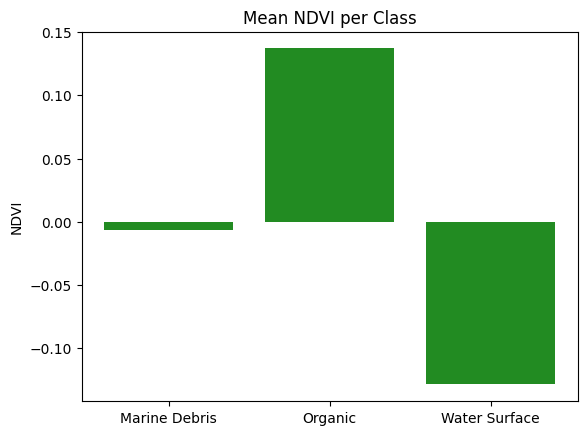

In [ ]:
mean_ndvi_per_class = {}

for i in range(len(dataset)):
    image, mask, _ = dataset[i]
    ndvi = image[3].numpy()
    for cls in [0, 1, 2]:
        if cls not in mean_ndvi_per_class:
            mean_ndvi_per_class[cls] = []
        mean_ndvi_per_class[cls].extend(ndvi[mask == cls])

mean_vals = {class_names[c]: np.mean(v) for c, v in mean_ndvi_per_class.items()}

plt.bar(mean_vals.keys(), mean_vals.values(), color='forestgreen')
plt.title("Mean NDVI per Class")
plt.ylabel("NDVI")
plt.show()


In [5]:
pip freeze >req.txt

Note: you may need to restart the kernel to use updated packages.
